In [52]:
import numpy as np 
import sunpy
import sunpy.map
from sunpy.coordinates import (propagate_with_solar_surface, 
        HeliocentricEarthEcliptic, get_body_heliographic_stonyhurst,
        get_horizons_coord)
import astropy
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, AsinhStretch
import astropy.units as u
import astropy.constants as const
import pyvista as pv

import matplotlib.pyplot as plt
import cmcrameri.cm as cmcm

In [29]:
spice_NeVIII_velmap = sunpy.map.Map("../../src/SPICE/20221024/lvl3/NeVIII_vel_deconv_plowman2023.fits")

In [6]:
spice_NeVIII_velmap_derot_shift_hrifov = sunpy.map.Map('../../src/coalign_map/20221024/spice_NeVIII_velmap_derot_shift_hrifov.fits')
spice_NeVIII_velmap_derot_shift_hrifov.plot_settings['aspect'] = spice_NeVIII_velmap_derot_shift_hrifov.scale.axis2/spice_NeVIII_velmap_derot_shift_hrifov.scale.axis1
spice_NeVIII_velmap_derot_shift_hrifov.plot_settings['norm'] = ImageNormalize(vmin=-40, vmax=40)
spice_NeVIII_velmap_derot_shift_hrifov.plot_settings['cmap'] = "RdBu_r"

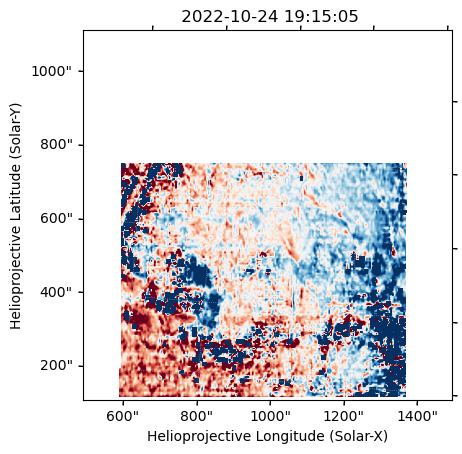

In [7]:
spice_NeVIII_velmap_derot_shift_hrifov.plot()

In [9]:
eis_auto_fit_184_velmap_shift = sunpy.map.Map('../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_184_velmap_shift.fits')
eis_auto_fit_184_velmap_shift.plot_settings['aspect'] = eis_auto_fit_184_velmap_shift.scale.axis2/eis_auto_fit_184_velmap_shift.scale.axis1
eis_auto_fit_184_velmap_shift.plot_settings['norm'] = ImageNormalize(vmin=-15, vmax=15)
eis_auto_fit_184_velmap_shift.plot_settings['cmap'] = "RdBu_r"

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]


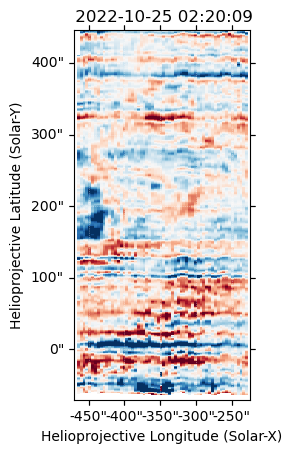

In [10]:
eis_auto_fit_184_velmap_shift.plot()

In [11]:
hri_174_map_shifted_toaia = sunpy.map.Map("../../src/coalign_map/20221024/hri_174_map_shifted_toaia.fits")

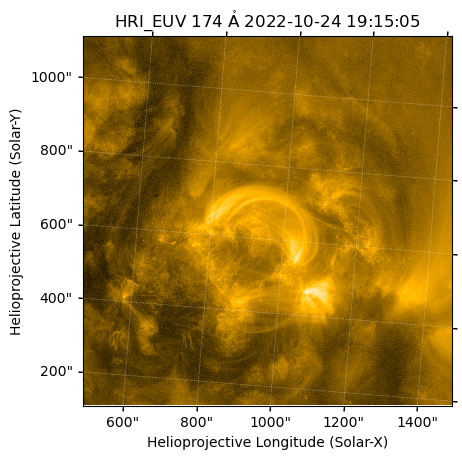

In [12]:
hri_174_map_shifted_toaia.plot()

In [15]:
with propagate_with_solar_surface(rotation_model="rigid"):
    eis_auto_fit_184_velmap_shift_derot_repro_hrifov = eis_auto_fit_184_velmap_shift.reproject_to(hri_174_map_shifted_toaia.wcs)

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/wcsaxes/patches.py:196: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


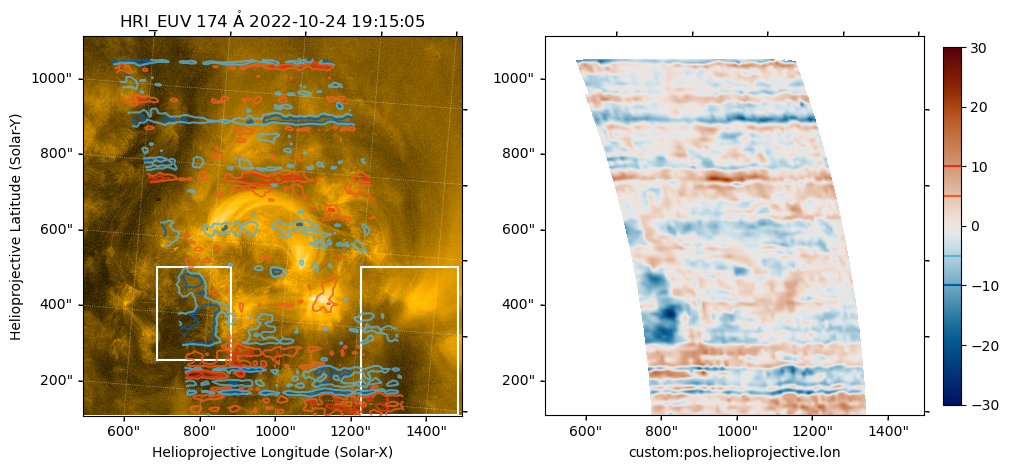

In [21]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

ax1 = fig.add_subplot(121,projection=hri_174_map_shifted_toaia)
im1 = hri_174_map_shifted_toaia.plot()

eis_auto_fit_184_velmap_shift_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],axes=ax1,alpha=0.8)

ax2 = fig.add_subplot(122,projection=hri_174_map_shifted_toaia)
im2 = ax2.imshow(eis_auto_fit_184_velmap_shift_derot_repro_hrifov.data,vmin=-30,vmax=30,cmap=cmcm.vik,origin="lower")
clb = plt.colorbar(im2,ax=ax2,shrink=0.8)
for level_, color_ in zip([-10,-5,5,10],["#005CAF","#58B2DC","#F05E1C","#E83015"]):
    clb.ax.axhline(level_,color=color_)

bounds = ax1.axis()
hri_174_map_shifted_toaia.draw_quadrangle([400,300]*u.pix,top_right=[800,800]*u.pix, 
                                    axes=ax1, color="w", lw=1.5)
hri_174_map_shifted_toaia.draw_quadrangle([1500,0]*u.pix,top_right=[2029,800]*u.pix, 
                                    axes=ax1, color="w", lw=1.5)
ax1.axis(bounds)
ax2.set_ylabel(" ")

In [25]:
seed_pixels = np.where(eis_auto_fit_184_velmap_shift_derot_repro_hrifov.data < - 25)
seed_pixels_skycoord = eis_auto_fit_184_velmap_shift_derot_repro_hrifov.pixel_to_world(seed_pixels[1]*u.pix,seed_pixels[0]*u.pix)

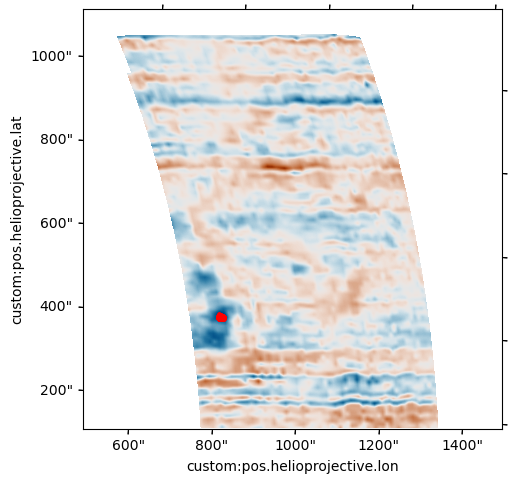

In [26]:
fig = plt.figure(figsize=(5,5),constrained_layout=True)
ax1 = fig.add_subplot(111,projection=hri_174_map_shifted_toaia)
im1 = ax1.imshow(eis_auto_fit_184_velmap_shift_derot_repro_hrifov.data,vmin=-30,vmax=30,cmap=cmcm.vik,origin="lower")

# ax1.scatter(seed_pixels[1],seed_pixels[0],color="r",s=1)
ax1.plot_coord(seed_pixels_skycoord,marker="o",markersize=2,linestyle="None",color="r")

In [27]:
vel_seed_FeX_184 = np.nanmean(eis_auto_fit_184_velmap_shift_derot_repro_hrifov.data[seed_pixels])
vel_seed_NeVIII_770 = np.nanmean(spice_NeVIII_velmap_derot_shift_hrifov.data[seed_pixels])

In [28]:
print(vel_seed_FeX_184, vel_seed_NeVIII_770)

-26.09001221822057 -34.2143070134646


In [30]:
hinode_observer = eis_auto_fit_184_velmap_shift.observer_coordinate
spice_observer = spice_NeVIII_velmap.observer_coordinate
hinode_observer_spice_frame = hinode_observer.transform_to(spice_observer.frame)
with propagate_with_solar_surface(rotation_model="rigid"):
    seed_pixel_coord0_spice_frame = seed_pixels_skycoord[0].transform_to(spice_observer.frame)

In [31]:
# return unit vector pointing from coord1 to coord2
def get_unit_vector(coord1,coord2):
    xyz = coord2.cartesian.xyz - coord1.cartesian.xyz
    return xyz/np.linalg.norm(xyz)

In [33]:
hinode_unit_vec = get_unit_vector(seed_pixel_coord0_spice_frame,hinode_observer_spice_frame).value
hinode_unit_vec

array([0.99615941, 0.00446497, 0.08744422])

In [34]:
spice_unit_vec = get_unit_vector(seed_pixel_coord0_spice_frame,spice_observer).value
spice_unit_vec

array([ 0.62771847, -0.77047509,  0.11107501])

In [35]:
epipolar_plane_normvec = np.cross(hinode_unit_vec,spice_unit_vec)

In [36]:
angle_hinode_spice = np.arccos(np.dot(hinode_unit_vec,spice_unit_vec))*u.rad

In [37]:
matrix_A = np.array([hinode_unit_vec,spice_unit_vec,epipolar_plane_normvec])
vector_B = np.array([np.abs(vel_seed_FeX_184),np.abs(vel_seed_NeVIII_770),0])

vec_ep = np.linalg.solve(matrix_A,vector_B)

In [38]:
vec_ep

array([ 25.94743226, -22.70051677,   3.92925296])

In [39]:
vec_eq_mag = np.linalg.norm(vec_ep)

In [44]:
fake_vec_eq_xyz = seed_pixel_coord0_spice_frame.cartesian.xyz + vec_ep*0.007*const.R_sun

In [45]:
fake_vec_eq_coord = SkyCoord(fake_vec_eq_xyz[0],fake_vec_eq_xyz[1],fake_vec_eq_xyz[2],frame=spice_observer.frame,
                             representation_type="cartesian").transform_to("heliographic_stonyhurst")

In [46]:
with propagate_with_solar_surface(rotation_model="rigid"):
    fake_vec_arrow_to_plot = astropy.coordinates.concatenate((fake_vec_eq_coord.transform_to(hri_174_map_shifted_toaia.coordinate_frame),
                                                            seed_pixel_coord0_spice_frame.transform_to(hri_174_map_shifted_toaia.coordinate_frame)))

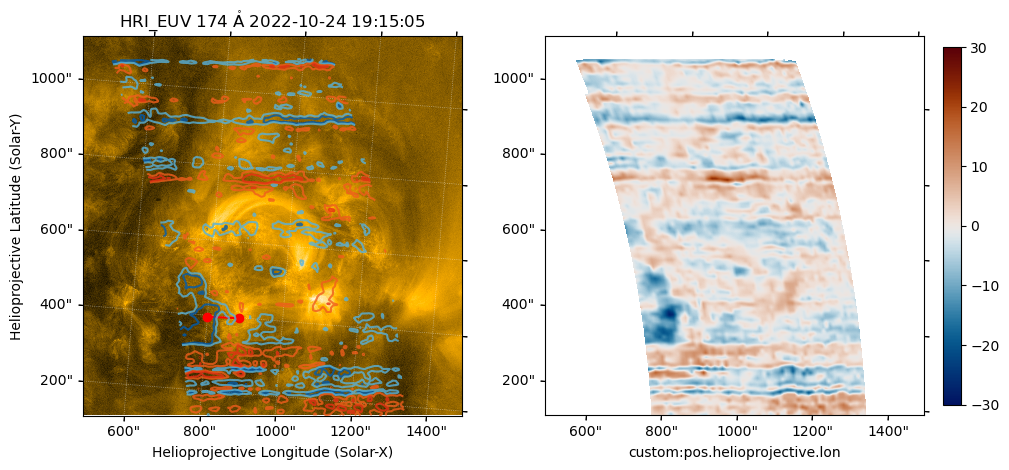

In [47]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

ax1 = fig.add_subplot(121,projection=hri_174_map_shifted_toaia)
im1 = hri_174_map_shifted_toaia.plot()
ax1.plot_coord(fake_vec_arrow_to_plot,marker="o",linestyle="-",color="r")

eis_auto_fit_184_velmap_shift_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],axes=ax1,alpha=0.8)

ax2 = fig.add_subplot(122,projection=hri_174_map_shifted_toaia)
im2 = ax2.imshow(eis_auto_fit_184_velmap_shift_derot_repro_hrifov.data,vmin=-30,vmax=30,cmap=cmcm.vik,origin="lower")
clb = plt.colorbar(im2,ax=ax2,shrink=0.8)
# for level_, color_ in zip([-10,-5,5,10],["#005CAF","#58B2DC","#F05E1C","#E83015"]):
#     clb.ax.axhline(level_,color=color_)


ax2.set_ylabel(" ")

In [48]:
def coord_to_heexy(coord,hee_frame):
    coord = coord.transform_to(hee_frame)
    coord.representation_type = 'cartesian'
    return coord.y.to_value('AU'), coord.x.to_value('AU')

In [49]:
def get_first_orbit(coord,hee_frame):
    lon = coord.transform_to(hee_frame).spherical.lon
    shifted = astropy.coordinates.Longitude(lon - lon[0])
    ends = np.flatnonzero(np.diff(shifted) < 0)
    if ends.size > 0:
        return coord[:ends[0]+1]
    return coord

In [50]:
planets = ['Earth']
times = spice_observer.obstime + np.arange(700) * u.day
planet_coords = {planet: get_first_orbit(get_body_heliographic_stonyhurst(planet, times),spice_observer.frame)
                 for planet in planets}

In [53]:
missions = ['Parker Solar Probe', 'Solar Orbiter',]
mission_labels = {'Parker Solar Probe': 'PSP', 'Solar Orbiter': 'SO'}
mission_coords = {mission: get_first_orbit(get_horizons_coord(mission, {'start': spice_observer.obstime,
                                                                        'stop': spice_observer.obstime + 1.2 * u.yr,
                                                                        'step': '1d'}),spice_observer.frame)
                  for mission in missions}

INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


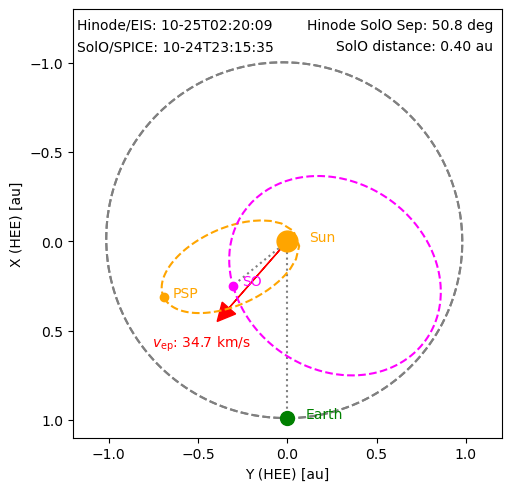

In [54]:
fig, ax = plt.subplots(figsize=(5,5),constrained_layout=True)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(1.1, -1.3)
ax.set_aspect('equal')
ax.plot([0, 0], [0, 1], linestyle='dotted', color='gray')

for planet, coord in planet_coords.items():
    ax.plot(*coord_to_heexy(coord,spice_observer.frame), linestyle='dashed', color='gray')

    if planet == 'Earth':
        color, markersize, offset = 'lime', 10, 0.1
    else:
        color, markersize, offset = 'gray', None, 0.05

for mission, coord in mission_coords.items():
    color = 'magenta' if mission == 'Solar Orbiter' else 'orange'

    ax.plot(*coord_to_heexy(coord,spice_observer.frame), linestyle='dashed', color=color)

    x, y = coord_to_heexy(coord[0],spice_observer.frame)
    if mission == 'Solar Orbiter':
        ax.plot([0, 1*x], [0, 1*y], linestyle='dotted', color='gray')
    ax.plot(x, y, 'o', color=color)

    ax.text(x + 0.05, y, mission_labels[mission], color=color)

for planet, coord in planet_coords.items():
    ax.plot(*coord_to_heexy(coord,spice_observer.frame), linestyle='dashed', color='gray')

    if planet == 'Earth':
        color, markersize, offset = 'green', 10, 0.1
    else:
        color, markersize, offset = 'gray', None, 0.05

    x, y = coord_to_heexy(coord[0],spice_observer.frame)
    ax.plot(x, y, 'o', markersize=markersize, color=color)
    ax.text(x + offset, y, planet, color=color)

ax.plot(0, 0, 'o', markersize=15, color='orange')
ax.text(0.12, 0, 'Sun', color='orange')

ax.set_xlabel('Y (HEE) [au]')
ax.set_ylabel('X (HEE) [au]')

ax.text(0.98,0.98,f"Hinode SolO Sep: {angle_hinode_spice.to(u.deg).value:.1f} deg",transform=ax.transAxes,ha="right",va="top")
ax.text(0.98,0.93,f"SolO distance: {spice_observer.radius.to(u.au).value:.2f} au",transform=ax.transAxes,ha="right",va="top")
ax.text(0.3,0.22,r"$v_{{\rm ep}}$: {:.1f} km/s".format(np.linalg.norm(vec_ep)),transform=ax.transAxes,ha="center",va="center",
        color="red")

ax.text(0.01,0.98,f"Hinode/EIS: {hinode_observer.obstime.isot[5:-4]}",transform=ax.transAxes,ha="left",va="top")
ax.text(0.01,0.93,f"SolO/SPICE: {spice_observer.obstime.isot[5:-4]}",transform=ax.transAxes,ha="left",va="top")

ax.arrow(0, 0, vec_ep[1]/np.linalg.norm(vec_ep)/2, vec_ep[0]/np.linalg.norm(vec_ep)/2, head_width=0.1, head_length=0.1, fc='r', ec='r')

plt.savefig("../../figs/test_figs/epipolar_velocity.png",dpi=300,bbox_inches="tight")

In [55]:
hri_174_map_shifted_toaia_all_coord = sunpy.map.all_coordinates_from_map(hri_174_map_shifted_toaia)

In [56]:
hri_174_map_shifted_toaia_all_coord = hri_174_map_shifted_toaia_all_coord.make_3d()

In [57]:
hri_174_map_shifted_toaia_all_coord_hee = hri_174_map_shifted_toaia_all_coord.transform_to(hri_174_map_shifted_toaia.observer_coordinate)

In [58]:
with propagate_with_solar_surface(rotation_model="rigid"):
    hri_174_map_shifted_toaia_all_coord_hee_spice = hri_174_map_shifted_toaia_all_coord_hee.transform_to(spice_observer.frame)

In [59]:
hri_174_map_shifted_toaia_3d_grid = pv.StructuredGrid(hri_174_map_shifted_toaia_all_coord_hee_spice.cartesian.x.to_value("AU"),
                                                      hri_174_map_shifted_toaia_all_coord_hee_spice.cartesian.y.to_value("AU"),
                                                     hri_174_map_shifted_toaia_all_coord_hee_spice.cartesian.z.to_value("AU"))

In [60]:
seed_pixel_coord0_spice_frame

<SkyCoord (HeliographicStonyhurst: obstime=2022-10-24T23:15:35.745, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-29.58016981, 15.27442957, 6.96e+08)>

In [61]:
seed_pixel_coord0_spice_frame.cartesian.xyz.to_value("AU")

array([ 0.00390317, -0.00221552,  0.00122566])

In [71]:
pv_plotter = pv.Plotter(notebook=True)

hri_174_map_shifted_toaia_3d_norm = ImageNormalize(vmin=0,vmax=1.5e4,stretch=AsinhStretch(0.05))
pv_plotter.add_mesh(hri_174_map_shifted_toaia_3d_grid,scalars=hri_174_map_shifted_toaia_3d_norm(hri_174_map_shifted_toaia.data), cmap="solar orbiterhri_euv174")
pv_plotter.add_arrows(seed_pixel_coord0_spice_frame.cartesian.xyz.to_value("AU"),vec_ep, mag=1e-5,color="lime")
pv_plotter.add_arrows(seed_pixel_coord0_spice_frame.cartesian.xyz.to_value("AU"),-hinode_unit_vec*vel_seed_FeX_184, 
                                    mag=1e-5,color="red")
pv_plotter.add_arrows(seed_pixel_coord0_spice_frame.cartesian.xyz.to_value("AU"),-spice_unit_vec*vel_seed_NeVIII_770, 
                                    mag=1e-5,color="blue")
pv_plotter.add_axes(line_width=5, labels_off=False)
pv_plotter.show()
pv_plotter.export_vtksz("../../figs/test_figs/hri_174_map_shifted_toaia_3d.vtksz")

del pv_plotter


Widget(value='<iframe src="http://localhost:35571/index.html?ui=P_0x7f7c501a2930_6&reconnect=auto" class="pyvi…

In [70]:
hinode_unit_vec*vel_seed_FeX_184, 

(array([-25.9898112 ,  -0.11649108,  -2.28142086]),)